# **EDA + Régression Logistique + PCA**


Bonjour à tous,

Ce notebook présente la **PCA (Analyse en Composantes Principales)** — une technique de **réduction de dimensionnalité**.

J'explique la PCA, le ratio de variance expliquée, l'utilisation de la régression logistique avec la PCA, comment choisir le nombre de dimensions approprié et comment tracer la variance expliquée en fonction du nombre de dimensions.

J'ai utilisé le jeu de données **adult** pour cet exemple. Ce jeu est assez petit pour la PCA ; l'objectif principal est de démontrer l'implémentation de la PCA avec ce jeu de données.

**J'espère que ce notebook vous sera utile — vos <font color="red"><b>UPVOTES</b></font> sont les bienvenus**

## Table des matières

Le contenu de ce notebook est divisé en plusieurs sections :

- La malédiction de la dimensionnalité
- Introduction à l'analyse en composantes principales (PCA)
- Importer les bibliothèques Python
- Importer le jeu de données
- Analyse exploratoire des données
- Séparer les données en ensembles d'entraînement et de test
- Feature engineering
- Mise à l'échelle des variables
- Régression logistique avec toutes les variables
- Régression logistique avec PCA
- Choisir le nombre de dimensions approprié
- Tracer la variance expliquée en fonction du nombre de dimensions
- Conclusion
- Références


## La malédiction de la dimensionnalité

En général, les jeux de données réels contiennent des milliers ou des millions de variables. Cela rend l'entraînement très lent et complique la recherche d'une bonne solution. Ce problème est souvent appelé la « malédiction de la dimensionnalité ».

La « malédiction de la dimensionnalité » regroupe plusieurs phénomènes qui apparaissent lorsque l'on manipule des données en espaces de grande dimension (souvent des centaines ou milliers de dimensions) et qui n'existent pas dans des espaces de faible dimension. Quand la dimension augmente, le volume de l'espace croît si vite que les données disponibles deviennent clairsemées, ce qui pose problème pour les méthodes statistiques.

Dans de nombreux problèmes réels, il est possible de réduire considérablement le nombre de dimensions. Ce processus s'appelle la réduction de dimensionnalité. Il permet d'accélérer l'entraînement et d'améliorer la visualisation des données.

La technique la plus populaire de réduction de dimensionnalité est l'analyse en composantes principales (PCA), présentée ci‑dessous.

## Introduction à l'analyse en composantes principales (PCA)

**L'analyse en composantes principales (PCA)** est une technique de réduction de dimensionnalité permettant de transformer un grand ensemble de variables en un ensemble plus petit conservant l'essentiel de la variance.

### Préserver la variance

La PCA identifie d'abord l'hyperplan le plus proche des données, puis projette les données dessus. Avant de projeter l'ensemble d'entraînement sur un hyperplan de plus faible dimension, il faut choisir l'hyperplan qui maximise la variance préservée — c'est l'idée de la PCA.

### Composantes principales

La PCA identifie les axes qui expliquent la plus grande part de la variance cumulée dans l'ensemble d'entraînement. Ces axes sont appelés composantes principales. La PCA suppose que les données sont centrées ; les classes PCA de scikit‑learn effectuent automatiquement ce centrage.

### Projection en d dimensions

Une fois les composantes principales identifiées, on peut réduire la dimensionnalité en projetant les données sur les d premières composantes principales, ce qui conserve autant que possible la variance d'origine.

Passons maintenant à l'implémentation.

## Importer les bibliothèques Python

In [2]:
# Cet environnement Python 3 inclut de nombreuses bibliothèques analytiques utiles
# Il est défini par l'image Docker kaggle/python : https://github.com/kaggle/docker-python
# Par exemple, voici plusieurs paquets utiles à charger

import numpy as np # algèbre linéaire
import pandas as pd # traitement des données, E/S CSV (ex. pd.read_csv)


# importer les bibliothèques pour les graphiques
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# ignorer les warnings
import warnings
warnings.filterwarnings('ignore')


# Les fichiers de données sont dans le répertoire courant de travail.
# Par exemple, exécuter ceci affichera la liste des fichiers du répertoire courant


# Utilisation du module os pour interagir avec le système de fichiers
import os
print(os.listdir('.'))  # liste des fichiers dans le répertoire courant

# Les résultats écrits dans le répertoire courant sont sauvegardés comme output.

['.vscode', 'adult.csv', 'eda-logistic-regression-pca.ipynb', 'linear-regression-regularization-lasso-ridge.ipynb', 'water-quality-prediction-76-h2o-80-accuracy.ipynb', 'water_potability.csv']


### Vérifier la taille des fichiers

In [3]:
print('# Tailles des fichiers')
for f in os.listdir('.'):
    size_mb = round(os.path.getsize(os.path.join('.', f)) / 1000000, 2)
    print(f.ljust(40) + str(size_mb) + ' MB')


# Tailles des fichiers
.vscode                                 0.0 MB
adult.csv                               5.33 MB
eda-logistic-regression-pca.ipynb       0.03 MB
linear-regression-regularization-lasso-ridge.ipynb0.84 MB
water-quality-prediction-76-h2o-80-accuracy.ipynb2.23 MB
water_potability.csv                    0.53 MB


## Importer le jeu de données

In [4]:
%%time

# Lecture du fichier adult.csv situé dans le même répertoire que ce notebook
file = ('adult.csv')
df = pd.read_csv(file, encoding='latin-1')

CPU times: total: 141 ms
Wall time: 180 ms


## Analyse exploratoire des données

### Vérifier la forme du jeu de données

In [5]:
df.shape

(48842, 15)

Nous pouvons voir qu'il y a 32561 observations et 15 attributs dans le jeu de données.

### Aperçu du jeu de données

In [6]:
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


### Afficher le résumé du DataFrame

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


### Encoder `?` en `NaN`

In [8]:
df[df == '?'] = np.nan

### Vérifier à nouveau le résumé du DataFrame

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        46043 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       46033 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   47985 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


À présent, le résumé montre que les variables `workclass`, `occupation` et `native.country` contiennent des valeurs manquantes. Toutes ces variables sont de type catégoriel. Nous allons imputer les valeurs manquantes par la modalité la plus fréquente (mode).

### Imputer les valeurs manquantes avec la valeur la plus fréquente (mode)

In [15]:
for col in ['workclass', 'occupation', 'native-country']:
    df[col].fillna(df[col].mode()[0], inplace=True)

### Vérifier à nouveau la présence de valeurs manquantes

In [16]:
df.isnull().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

Nous pouvons maintenant constater qu'il n'y a plus de valeurs manquantes dans le jeu de données.

### Définir le vecteur de caractéristiques et la variable cible

In [11]:
X = df.drop(['income'], axis=1)

y = df['income']

In [12]:
X.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,Private,103497,Some-college,10,Never-married,Prof-specialty,Own-child,White,Female,0,0,30,United-States


## Séparer les données en ensembles d'entraînement et de test

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

## Ingénierie des caractéristiques (Feature Engineering)

### Encoder les variables catégorielles

In [18]:
from sklearn import preprocessing

categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']
for feature in categorical:
        le = preprocessing.LabelEncoder()
        X_train[feature] = le.fit_transform(X_train[feature])
        X_test[feature] = le.transform(X_test[feature])

## Mise à l'échelle des variables (Feature Scaling)

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)

X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)

In [20]:
X_train.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
0,-0.849978,-1.887643,-0.551219,1.212393,-0.027733,-0.406325,-1.554732,0.969833,0.390646,-1.425582,-0.144199,-0.216492,-0.034027,0.248175
1,0.241031,-0.094859,1.687545,-2.650223,-1.587187,-0.406325,-1.049322,0.969833,-0.797592,0.701468,-0.144199,-0.216492,0.207331,0.248175
2,-0.486308,1.697924,-1.434052,-0.590161,0.362131,-0.406325,-0.543912,-0.899325,0.390646,0.701468,0.850561,-0.216492,2.379553,0.248175
3,-0.195373,-0.094859,-0.384485,1.212393,-0.027733,0.922720,-0.796617,-0.276272,0.390646,-1.425582,-0.144199,-0.216492,1.575026,0.248175
4,-0.704510,-0.094859,1.608144,0.182362,-0.417596,1.587242,1.730434,1.592886,0.390646,-1.425582,-0.144199,-0.216492,-0.838553,0.248175


## Modèle de régression logistique avec toutes les variables

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Logistic Regression accuracy score with all the features: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Logistic Regression accuracy score with all the features: 0.8221


## Régression logistique avec PCA

La classe PCA de Scikit‑Learn implémente l'algorithme PCA. Avant d'entrer dans l'implémentation, voici un concept important : le ratio de variance expliquée.

### Ratio de variance expliquée

Le ratio de variance expliquée pour chaque composante principale est accessible via `explained_variance_ratio_`. Il indique la proportion de la variance totale du jeu de données expliquée par chaque composante principale.

Passons à l'implémentation de la PCA.

In [22]:
from sklearn.decomposition import PCA
pca = PCA()
X_train = pca.fit_transform(X_train)
pca.explained_variance_ratio_


array([0.14739983, 0.10130586, 0.08082405, 0.079168  , 0.07433087,
       0.07313079, 0.07066718, 0.06751986, 0.06517912, 0.06108265,
       0.06022374, 0.04864261, 0.04288742, 0.02763804])

### Remarque

- On observe qu'environ 97,25 % de la variance est expliquée par les 13 premières variables.

- Seuls 2,75 % de la variance sont expliqués par la dernière variable ; elle apporte donc peu d'information.

- Nous allons la supprimer, réentraîner le modèle et calculer la précision.


### Régression logistique avec les 13 premières variables

In [24]:
X = df.drop(['income','native-country'], axis=1)
y = df['income']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)


categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender']
for feature in categorical:
        le = preprocessing.LabelEncoder()
        X_train[feature] = le.fit_transform(X_train[feature])
        X_test[feature] = le.transform(X_test[feature])


X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)

X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Logistic Regression accuracy score with the first 13 features: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))


Logistic Regression accuracy score with the first 13 features: 0.8221


### Remarque

- On observe que la précision a diminué de 0,8218 à 0,8213 après la suppression de la dernière variable.

- Si l'on considère les deux dernières variables combinées, elles expliquent environ 7 % de la variance.

- Je vais les supprimer, réentraîner le modèle et recalculer la précision.

### Régression logistique avec les 12 premières variables

In [26]:
X = df.drop(['income','native-country', 'hours-per-week'], axis=1)
y = df['income']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)


categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender']
for feature in categorical:
        le = preprocessing.LabelEncoder()
        X_train[feature] = le.fit_transform(X_train[feature])
        X_test[feature] = le.transform(X_test[feature])


X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)

X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Logistic Regression accuracy score with the first 12 features: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))


Logistic Regression accuracy score with the first 12 features: 0.8229


### Remarque

- On constate que la précision a augmenté à 0,8227 lorsque le modèle est entraîné avec 12 variables.

- Enfin, en prenant les trois dernières variables combinées, environ 11,83 % de la variance est expliquée par elles.

- Je répéterai le processus : retirer ces variables, réentraîner le modèle et calculer la précision.

### Régression logistique avec les 11 premières variables

In [28]:
X = df.drop(['income','native-country', 'hours-per-week', 'capital-loss'], axis=1)
y = df['income']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)


categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender']
for feature in categorical:
        le = preprocessing.LabelEncoder()
        X_train[feature] = le.fit_transform(X_train[feature])
        X_test[feature] = le.transform(X_test[feature])


X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)

X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Logistic Regression accuracy score with the first 11 features: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))


Logistic Regression accuracy score with the first 11 features: 0.8174


### Remarque

- On voit que la précision a nettement diminué à 0.8187 si je supprime les trois dernières variables.

- Notre objectif est de maximiser la précision. La précision maximale observée est obtenue avec les 12 premières variables : 0.8227.

## Choisir le nombre de dimensions approprié

- La méthode ci‑dessus fonctionne bien pour un petit nombre de dimensions.

- Mais elle devient fastidieuse lorsque le nombre de dimensions est élevé.

- Dans ce cas, une meilleure approche consiste à calculer le nombre minimal de dimensions qui expliquent une grande part de la variance.

- Le code suivant calcule la PCA sans réduire la dimension, puis détermine le nombre minimal de dimensions nécessaires pour conserver 90 % de la variance de l'ensemble d'entraînement.

In [29]:
X = df.drop(['income'], axis=1)
y = df['income']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)


categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']
for feature in categorical:
        le = preprocessing.LabelEncoder()
        X_train[feature] = le.fit_transform(X_train[feature])
        X_test[feature] = le.transform(X_test[feature])


X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)


pca= PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
dim = np.argmax(cumsum >= 0.90) + 1
print('The number of dimensions required to preserve 90% of variance is',dim)


The number of dimensions required to preserve 90% of variance is 12


### Remarque

- Une fois le nombre de dimensions requis déterminé, on peut définir `dim` et exécuter la PCA avec ce nombre de composantes.

- Avec `dim` dimensions, on peut alors calculer la précision attendue du modèle.

## Tracer la variance expliquée en fonction du nombre de dimensions

- Une approche alternative consiste à tracer la variance expliquée cumulative en fonction du nombre de composantes.

- Dans ce graphe, on cherche un coude (« elbow ») où la variance expliquée cesse d'augmenter rapidement.

- Ce point peut être considéré comme la dimension intrinsèque du jeu de données.

- Ci‑dessous, nous traçons la variance cumulée expliquée par le nombre de composantes.

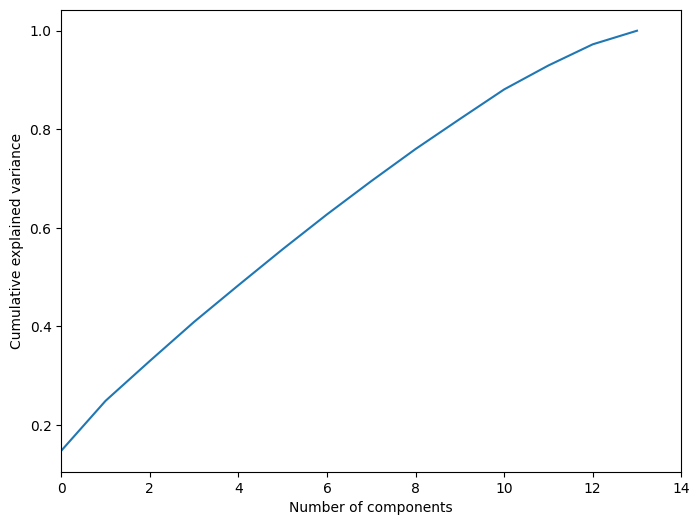

In [31]:
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,14)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

### Remarque

Le graphique ci‑dessus montre qu'environ 90 % de la variance est expliquée par les 12 premières composantes.

## Conclusion

- Dans ce notebook, j'ai présenté l'analyse en composantes principales (PCA), la technique de réduction de dimensionnalité la plus utilisée.
- J'ai démontré l'implémentation de la PCA avec une régression logistique sur le jeu de données `adult`.
- J'ai obtenu la meilleure précision avec les 12 premières variables (précision = 0.8227).
- Comme attendu, le nombre de dimensions requis pour préserver 90 % de la variance est de 12.
- Enfin, j'ai tracé la variance expliquée en fonction du nombre de dimensions : le graphe confirme qu'environ 90 % de la variance est expliquée par les 12 premières composantes.

## Références

Les idées et concepts présentés dans ce notebook sont issus du livre suivant :

- Hands-On Machine Learning with Scikit-Learn and TensorFlow par Aurélien Géron.